In [1]:
import os
%matplotlib inline 
from matplotlib import pyplot as plt
from skimage import io, color, exposure
from skimage.transform import rescale
from skimage.filters import unsharp_mask, sato, frangi, hessian
import numpy as np
import cv2


INPUT = "pictures/Image_05L.jpg"
SCALE = 1

### Additional functions

In [160]:
def showImages(img1, img2, img3):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))

    ax = axes.ravel()

    ax[0].imshow(img1, cmap='gray')
    ax[0].set_title("Original image")
    
    ax[1].imshow(img2, cmap='gray')
    ax[1].set_title("Deconvolved, binary")
    
    ax[2].imshow(img3, cmap='gray')
    ax[2].set_title("Expert")

### Preprocessing

In [3]:
def loadImage(path):
    image = io.imread(path)    
    return image

In [4]:
def scaleImage(image):
    return rescale(image, SCALE, anti_aliasing=True)

In [5]:
def img2grayscale(image):
    return color.rgb2gray(image)

In [6]:
def sharpening(image):
    return unsharp_mask(image, radius=5, amount=2)

In [7]:
def histEq(img):
    return exposure.equalize_hist(img)

In [8]:
def initialProcessing():
    img = loadImage(INPUT)
    #Skalowanie i zamiana na skale szarości
    imgNorm = scaleImage(img2grayscale(img))
    #Wyostrzanie obrazu (lepiej widać naczynia)
    imgSharp = sharpening(imgNorm)
    #Local histogram equalization
    imgEqualized = histEq(imgNorm)
    return imgEqualized

In [9]:
image = initialProcessing()

C:\Users\jansmi\Anaconda3\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


### Vessels finding

In [200]:
def detectVessels(image):
    #def frangi(image, sigmas=range(1, 10, 2), scale_range=None, scale_step=None,
    #       beta1=None, beta2=None, alpha=0.5, beta=0.5, gamma=15,
    #       black_ridges=True)
    image = sato(image)
    #image = frangi(image, gamma=0.15)
    return image

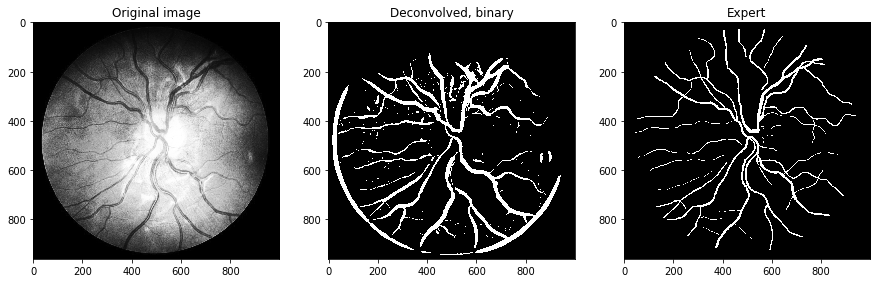

In [219]:
imgVessels = detectVessels(image)

expert = io.imread("pictures/Image_05L_2ndHO.png")
expert = scaleImage(expert)
expert = img2grayscale(expert)

binary = imgVessels > 0.025
showImages(image, binary, expert)

### Check correctness

In [229]:
sizeX, sizeY = len(image), len(image[0])

image_positives = int(np.sum(binary))
image_negatives = sizeX * sizeY - image_positives

sizeX, sizeY = len(expert), len(expert[0])

expert_positives = int(np.sum(expert))
expert_negatives = sizeX * sizeY - expert_positives

print(image_positives)
print(image_negatives)

print(expert_positives)
print(expert_negatives)

106131
852909
58733
900307


In [233]:
combination = binary * expert
print(combination)

# TP - correctly classified as positive
# TN -  correctly classified as negative
# FP - incorrectly classified as positive
# FN - incorrectly classified as negative

TP = int(np.sum(combination))
print(TP)

FP = image_positives - TP
print(FP)

#TN = 
#FN = 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
43217
62914


In [ ]:
#sensitivity = TP/(TP+FN)

#specificity = TN / (TN+FP)

#accuracy = (TN+TP) / (TN+TP+FN+FP)
